## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import numpy as np
from scipy.signal import hilbert
import gammatone.filters
from gammatone.gtgram import gtgram
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam
import joblib


## Load the Dataset

In [2]:
emotion_map = {
    '01': 'Netral',
    '02': 'Senang',
    '03': 'Terkejut',
    '04': 'Jijik',
    '05': 'Kecewa'
}

In [3]:
paths = []
actors = []
genders = []
emotions = []
intensities = []
repetitions = []

base_dir = 'dataset/IndoWaveSentiment/'
for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                paths.append(os.path.join(actor_path, filename))
                parts = filename.replace('.wav', '').split('-')
                actor = parts[0]
                emotion = parts[1]
                intensity = parts[2]
                repetition = parts[3]
                actors.append(actor)
                genders.append('Pria' if int(actor) % 2 == 1 else 'Wanita')
                emotions.append(emotion_map[emotion])
                intensities.append('Normal' if intensity == '01' else 'Strong')
                repetitions.append(repetition)

In [4]:
len(paths)

300

In [5]:
paths[:5]

['dataset/IndoWaveSentiment/Actor_01\\01-01-01-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-02.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-03.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-02.wav']

In [6]:
actor[:5]

'10'

In [7]:
genders[:5]

['Pria', 'Pria', 'Pria', 'Pria', 'Pria']

In [8]:
emotions[:5]

['Netral', 'Netral', 'Netral', 'Netral', 'Netral']

In [9]:
intensities[:5]

['Normal', 'Normal', 'Normal', 'Strong', 'Strong']

In [10]:
repetitions[:5]

['01', '02', '03', '01', '02']

In [4]:
## Create a dataframe
df = pd.DataFrame({
    'path': paths,
    'aktor': actors,
    'gender': genders,
    'emosi': emotions,
    'intensitas': intensities,
    'repetisi': repetitions
})
df.head()

path aktor gender   emosi  \
0  dataset/IndoWaveSentiment/Actor_01\01-01-01-01...    01   Pria  Netral   
1  dataset/IndoWaveSentiment/Actor_01\01-01-01-02...    01   Pria  Netral   
2  dataset/IndoWaveSentiment/Actor_01\01-01-01-03...    01   Pria  Netral   
3  dataset/IndoWaveSentiment/Actor_01\01-01-02-01...    01   Pria  Netral   
4  dataset/IndoWaveSentiment/Actor_01\01-01-02-02...    01   Pria  Netral   

  intensitas repetisi  
0     Normal       01  
1     Normal       02  
2     Normal       03  
3     Strong       01  
4     Strong       02

In [12]:
df['path'].value_counts()

path
dataset/IndoWaveSentiment/Actor_01\01-01-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-02.wav    1
                                                     ..
dataset/IndoWaveSentiment/Actor_04\04-02-02-01.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-03.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-02.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-01.wav    1
dataset/IndoWaveSentiment/Actor_10\10-05-02-03.wav    1
Name: count, Length: 300, dtype: int64

In [14]:
df['aktor'].value_counts()

aktor
01    30
02    30
03    30
04    30
05    30
06    30
07    30
08    30
09    30
10    30
Name: count, dtype: int64

In [15]:
df['gender'].value_counts()

gender
Pria      150
Wanita    150
Name: count, dtype: int64

In [16]:
df['emosi'].value_counts()

emosi
Netral      60
Senang      60
Terkejut    60
Jijik       60
Kecewa      60
Name: count, dtype: int64

In [17]:
df['intensitas'].value_counts()

intensitas
Normal    150
Strong    150
Name: count, dtype: int64

In [18]:
df['repetisi'].value_counts()

repetisi
01    100
02    100
03    100
Name: count, dtype: int64

## Exploratory Data Analysis

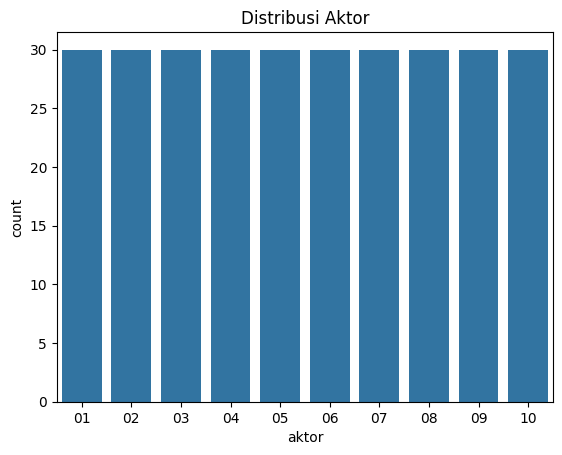

In [19]:
sns.countplot(data=df, x='aktor')
plt.title('Distribusi Aktor')
plt.show()

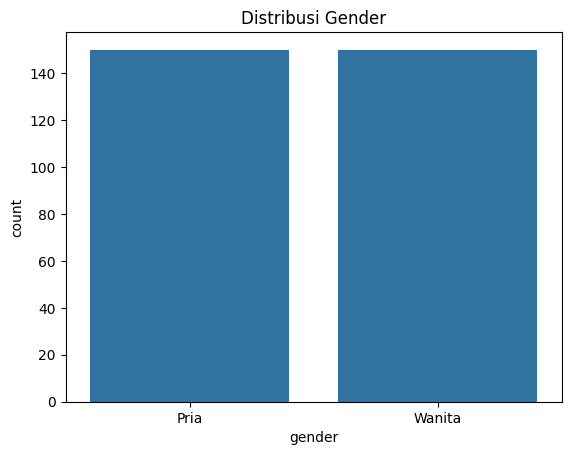

In [20]:
sns.countplot(data=df, x='gender')
plt.title('Distribusi Gender')
plt.show()

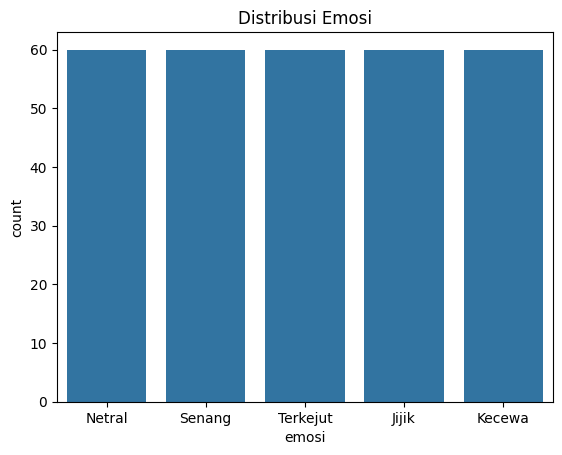

In [21]:
sns.countplot(data=df, x='emosi')
plt.title('Distribusi Emosi')
plt.show()

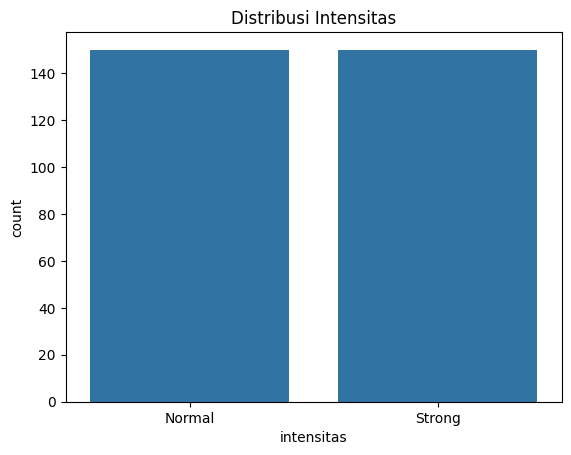

In [22]:
sns.countplot(data=df, x='intensitas')
plt.title('Distribusi Intensitas')
plt.show()

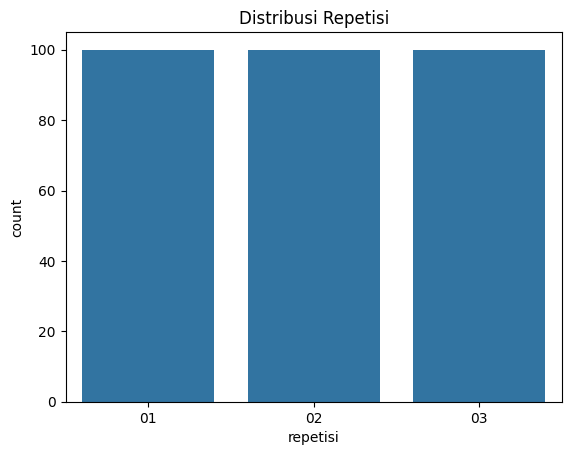

In [23]:
sns.countplot(data=df, x='repetisi')
plt.title('Distribusi Repetisi')
plt.show()

In [24]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

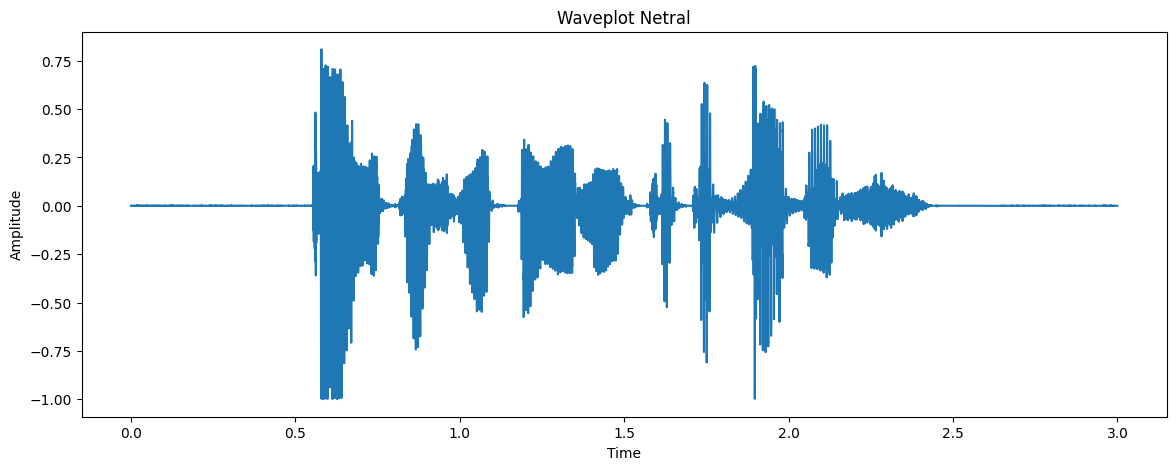

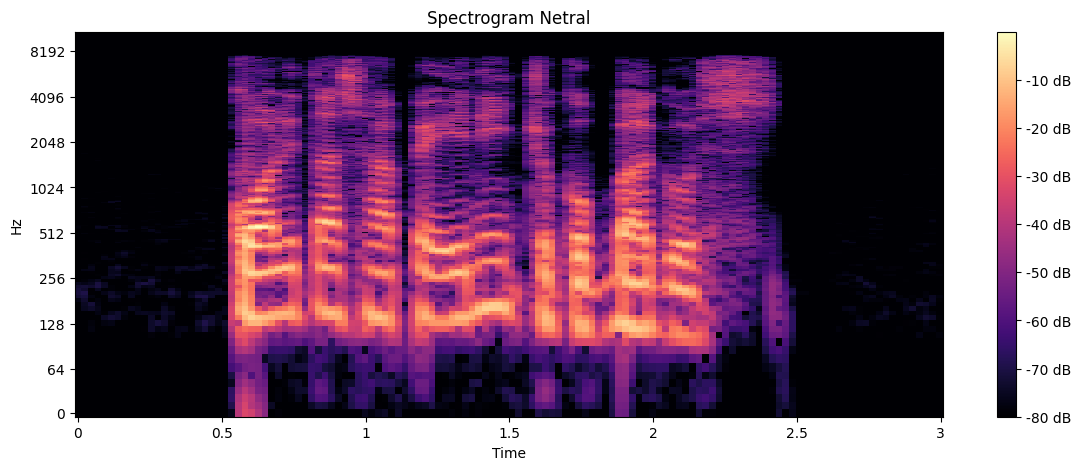

In [25]:
emotion = 'Netral'
paths = np.array(df['path'][df['emosi'] == emotion])[0]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Netral')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Netral')
plt.show()
Audio(paths)

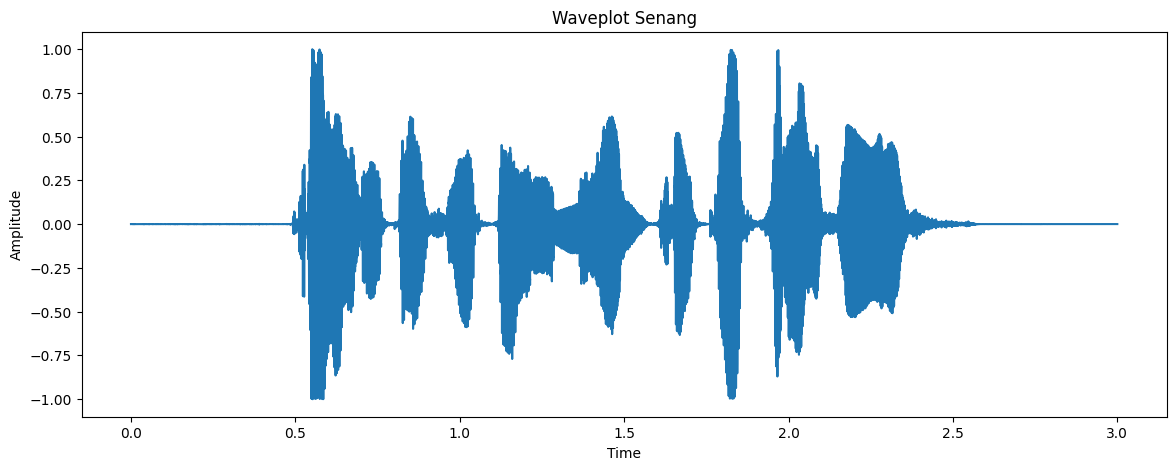

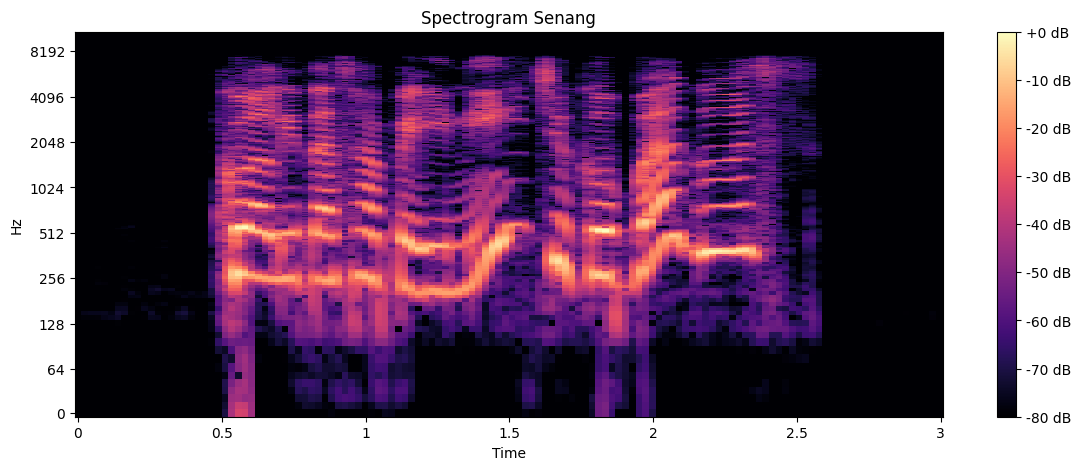

In [26]:
emotion = 'Senang'
paths = np.array(df['path'][df['emosi'] == emotion])[10]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Senang')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Senang')
plt.show()
Audio(paths)

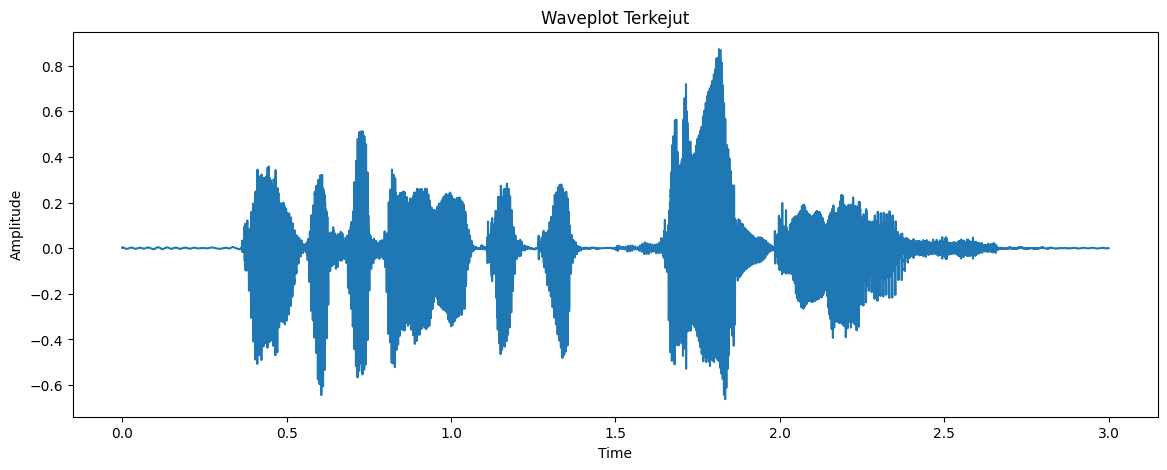

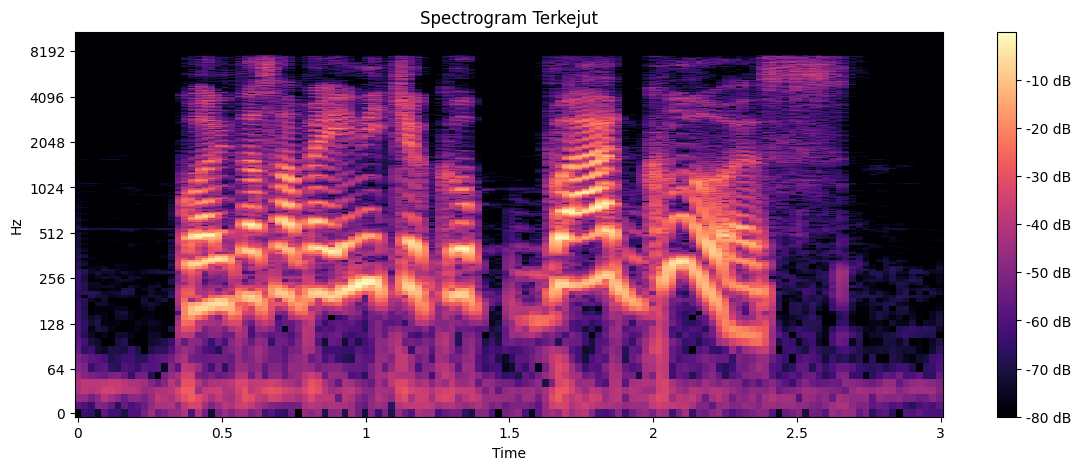

In [27]:
emotion = 'Terkejut'
paths = np.array(df['path'][df['emosi'] == emotion])[16]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Terkejut')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Terkejut')
plt.show()
Audio(paths)

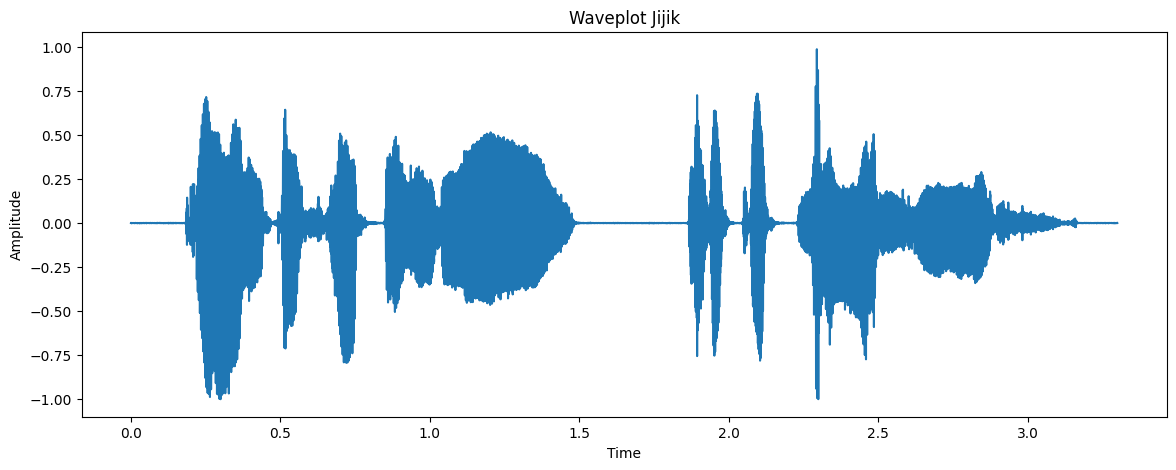

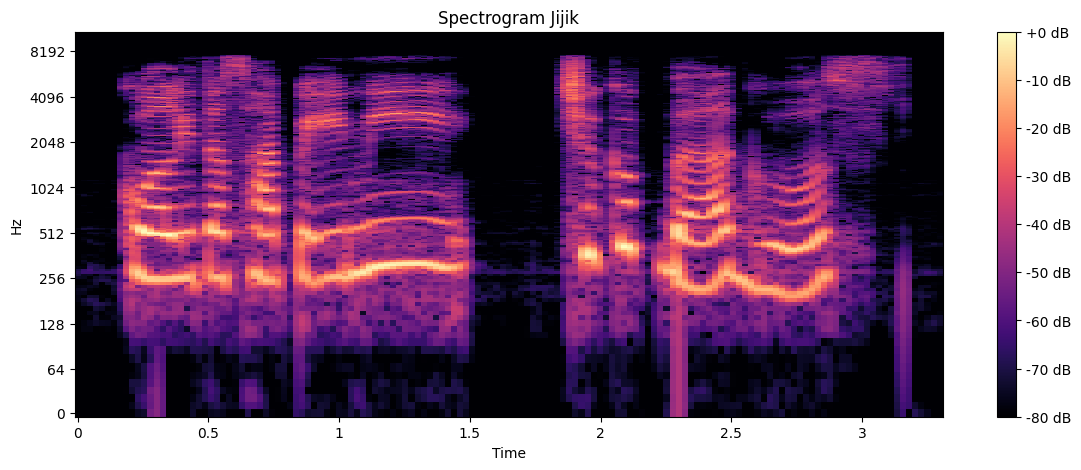

In [28]:
emotion = 'Jijik'
paths = np.array(df['path'][df['emosi'] == emotion])[35]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Jijik')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Jijik')
plt.show()
Audio(paths)

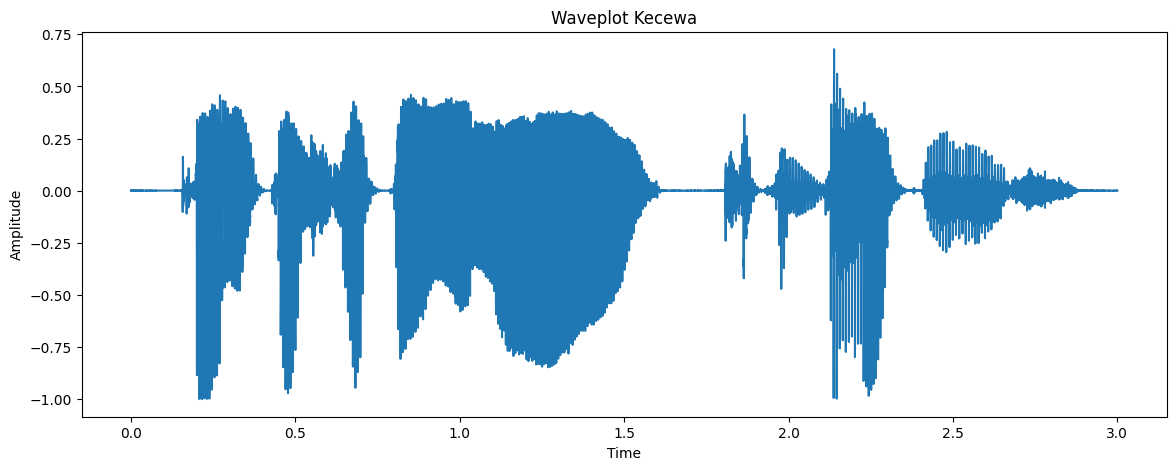

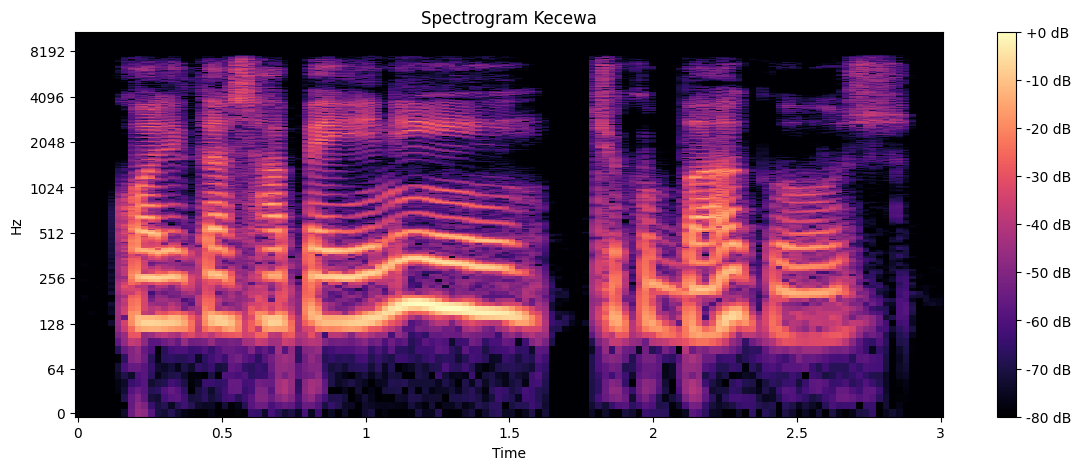

In [29]:
emotion = 'Kecewa'
paths = np.array(df['path'][df['emosi'] == emotion])[50]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Kecewa')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Kecewa')
plt.show()
Audio(paths)

## Feature Extraction

### MFCC

In [5]:
def extract_mfcc(filename, n_mfcc=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

#### DataFrame

In [6]:
X_mfcc = df['path'].apply(lambda x: extract_mfcc(x))
mfcc = np.stack(X_mfcc.values)
X_mfcc

0      [-310.3727, 89.42707, -5.002537, 45.108185, -2...
1      [-293.58374, 96.594345, -6.6026344, 49.63558, ...
2      [-275.0798, 96.307755, -5.3895497, 52.651905, ...
3      [-300.9955, 86.69134, -4.7884502, 37.07431, -2...
4      [-296.57416, 97.53068, -4.8118505, 43.048214, ...
                             ...                        
295    [-322.98322, 84.86375, 4.3241076, 36.054813, -...
296    [-315.5319, 84.19446, 0.0055141924, 33.952553,...
297    [-342.7631, 94.137825, -1.906536, 30.528961, -...
298    [-367.06488, 98.17489, 11.441321, 34.113586, -...
299    [-342.96817, 88.019485, 0.50365645, 33.983727,...
Name: path, Length: 300, dtype: object

In [7]:
mfcc = [x for x in X_mfcc]
mfcc = np.array(mfcc)
mfcc.shape 

(300, 40)

In [8]:
## input split
mfcc = np.expand_dims(mfcc, -1)
mfcc.shape

(300, 40, 1)

### Multispektrum Hilbert

In [9]:
def extract_hilbert_spectrum(filename, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    analytic_signal = hilbert(y)
    envelope = np.abs(analytic_signal)
    spectrum = np.abs(np.fft.fft(envelope))
    spectrum = spectrum[:len(spectrum)//2]  # Ambil separuh (nyquist)
    # 15 statistik fitur dari envelope/spectrum
    features = [
        np.mean(envelope),
        np.std(envelope),
        np.max(envelope),
        np.min(envelope),
        np.median(envelope),
        np.percentile(envelope, 25),
        np.percentile(envelope, 75),
        np.mean(spectrum),
        np.std(spectrum),
        np.max(spectrum),
        np.min(spectrum),
        np.median(spectrum),
        np.percentile(spectrum, 25),
        np.percentile(spectrum, 75),
        np.sum(envelope**2)  # energy
    ]
    return np.array(features)  # shape: (15,)

#### DataFrame

In [10]:
X_hilbert_spectrum = df['path'].apply(lambda x: extract_hilbert_spectrum(x))
hilbert_spectrum = np.stack(X_hilbert_spectrum.values)
X_hilbert_spectrum

0      [0.09354490786790848, 0.14071166515350342, 1.1...
1      [0.10645010322332382, 0.14868754148483276, 1.2...
2      [0.11742860823869705, 0.1643792986869812, 1.17...
3      [0.10615934431552887, 0.15599283576011658, 1.3...
4      [0.1034325584769249, 0.14503887295722961, 1.09...
                             ...                        
295    [0.13537363708019257, 0.14154790341854095, 1.0...
296    [0.14503295719623566, 0.14839957654476166, 1.2...
297    [0.12333542108535767, 0.12206174433231354, 0.4...
298    [0.10406363010406494, 0.10466554015874863, 0.4...
299    [0.12454231083393097, 0.12590137124061584, 0.5...
Name: path, Length: 300, dtype: object

In [11]:
hilbert_spectrum = [x for x in X_hilbert_spectrum]
hilbert_spectrum = np.array(hilbert_spectrum)
hilbert_spectrum.shape

(300, 15)

In [12]:
## input split
hilbert_spectrum = np.expand_dims(hilbert_spectrum, -1)
hilbert_spectrum.shape

(300, 15, 1)

### Cochleagram

In [ ]:
def extract_cochleagram(filename, n_bands=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    # Parameter gtgram: (signal, fs, window_time, hop_time, channels, f_min)
    window_time = 0.025  # 25 ms window
    hop_time = 0.010     # 10 ms hop
    f_min = 50           # Minimum frequency
    # gtgram menghasilkan matriks (n_bands, n_frames)
    cochleagram = gtgram(y, sr, window_time, hop_time, n_bands, f_min)
    # Ambil rata-rata per band (axis=1) untuk vektor fitur
    cochleagram_features = np.mean(cochleagram, axis=1)
    
    return cochleagram_features    

#### DataFrame

In [14]:
X_cochleagram = df['path'].apply(lambda x: extract_cochleagram(x))
cochleagram = np.stack(X_cochleagram.values)
X_cochleagram

0      [0.0005457932336173398, 0.0024897357673786466,...
1      [0.0006170102994991779, 0.002960471769311592, ...
2      [0.000684701532745724, 0.0032143317306341677, ...
3      [0.0008232640771210891, 0.0021796810543438776,...
4      [0.0007159399233960925, 0.002376610643315366, ...
                             ...                        
295    [0.0003233654224053848, 0.0007264485836519567,...
296    [0.00033681808910627906, 0.0007365669055040537...
297    [0.00014938951975930443, 0.0003301573827922905...
298    [0.00015108883794417023, 0.0003317740607166440...
299    [0.0001956450387799354, 0.00035289785049624084...
Name: path, Length: 300, dtype: object

In [15]:
cochleagram = [x for x in X_cochleagram]
cochleagram = np.array(cochleagram)
cochleagram.shape 

(300, 40)

In [16]:
## input split
cochleagram = np.expand_dims(cochleagram, -1)
cochleagram.shape

(300, 40, 1)

### Menggabungkan semua fitur

In [17]:
# Gabungkan Fitur dengan Konsisten cochleagram_flat
def extract_hybrid_features(filename):
    mfcc = extract_mfcc(filename)  # (40,)
    hilbert = extract_hilbert_spectrum(filename)  # (15,)
    cochleagram = extract_cochleagram(filename)  # (64, 192)
    return np.concatenate([mfcc, hilbert, cochleagram])

#### DataFrame

In [18]:
X_hybrid = df['path'].apply(lambda x: extract_hybrid_features(x))
hybrid = np.stack(X_hybrid.values)
print(hybrid.shape)

(300, 95)


In [19]:
hybrid = [x for x in X_hybrid]
hybrid = np.array(hybrid)
hybrid.shape 

(300, 95)

In [20]:
# input split
hybrid = np.expand_dims(hybrid, -1)
print(hybrid.shape)

(300, 95, 1)


## Encoding Label Emosi

In [21]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['emosi']])
y = y.toarray()
y.shape

(300, 5)

In [22]:
print(enc.categories_[0])
print(sorted(df['emosi'].unique()))

['Jijik' 'Kecewa' 'Netral' 'Senang' 'Terkejut']
['Jijik', 'Kecewa', 'Netral', 'Senang', 'Terkejut']


In [ ]:
joblib.dump(enc, 'dataset/onehotencoder.pkl')

['dataset/label_encoder.pkl']

## Scaler

In [23]:
scaler = MinMaxScaler()
hybrid_scaled = scaler.fit_transform(hybrid.reshape(hybrid.shape[0], -1))
hybrid_scaled

array([[0.57511526, 0.46515923, 0.69448393, ..., 0.18141552, 0.19598425,
        0.25133351],
       [0.67063311, 0.56200957, 0.67076353, ..., 0.41747098, 0.42567847,
        0.43028684],
       [0.77590796, 0.55813691, 0.68874671, ..., 0.37713276, 0.3972059 ,
        0.44687351],
       ...,
       [0.39083597, 0.52881497, 0.7403801 , ..., 0.17666011, 0.28263061,
        0.37892224],
       [0.25257528, 0.58336723, 0.93825328, ..., 0.07758723, 0.15238372,
        0.23951547],
       [0.38966921, 0.44613874, 0.77610961, ..., 0.19623464, 0.28089307,
        0.38001961]])

In [ ]:
joblib.dump(scaler, 'dataset/scaler_hybrid.pkl')

In [24]:
hybrid_scaled = np.expand_dims(hybrid_scaled, axis=-1)
hybrid_scaled

array([[[0.57511526],
        [0.46515923],
        [0.69448393],
        ...,
        [0.18141552],
        [0.19598425],
        [0.25133351]],

       [[0.67063311],
        [0.56200957],
        [0.67076353],
        ...,
        [0.41747098],
        [0.42567847],
        [0.43028684]],

       [[0.77590796],
        [0.55813691],
        [0.68874671],
        ...,
        [0.37713276],
        [0.3972059 ],
        [0.44687351]],

       ...,

       [[0.39083597],
        [0.52881497],
        [0.7403801 ],
        ...,
        [0.17666011],
        [0.28263061],
        [0.37892224]],

       [[0.25257528],
        [0.58336723],
        [0.93825328],
        ...,
        [0.07758723],
        [0.15238372],
        [0.23951547]],

       [[0.38966921],
        [0.44613874],
        [0.77610961],
        ...,
        [0.19623464],
        [0.28089307],
        [0.38001961]]])

In [25]:
hybrid_scaled.shape

(300, 95, 1)

In [26]:
# Split data hybrid_scaled
X_train, X_test, y_train, y_test = train_test_split(hybrid_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Hasil Visual dari 3 Ekstraksi Fitur

In [ ]:
# Ambil satu sampel data untuk divisualisasikan
i = 10  # indeks audio yang ingin divisualisasikan
audio_path = paths[i]

# Load ulang audio (untuk visualisasi)
y, sr = librosa.load(audio_path, sr=None)

# Hitung ulang fitur MFCC, Hilbert, dan Cochleagram
mfcc_feat = extract_mfcc(audio_path)
hilbert_feat = extract_hilbert_spectrum(audio_path)
cochlea_feat = extract_cochleagram(audio_path)

# Hybrid vector
hybrid_vector = np.concatenate([mfcc_feat, hilbert_feat, cochlea_feat])

Text(0.5, 1.0, 'MFCC (40 Coefficients)')

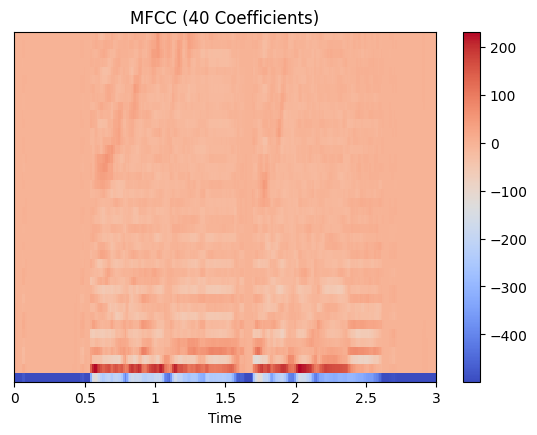

In [ ]:
# Visualisasi MFCC
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
mfcc_matrix = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfcc_matrix, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC (40 Coefficients)')

Text(0, 0.5, 'Nilai')

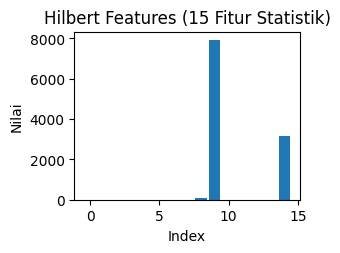

In [44]:
# Visualisasi Hilbert (bar chart 15 fitur)
plt.subplot(2, 2, 2)
plt.bar(range(len(hilbert_feat)), hilbert_feat)
plt.title('Hilbert Features (15 Fitur Statistik)')
plt.xlabel('Index')
plt.ylabel('Nilai')

Text(0, 0.5, 'Channel')

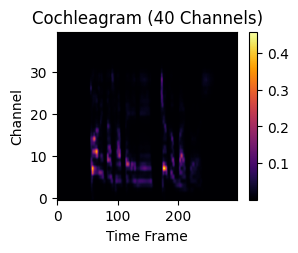

In [45]:
# Visualisasi Cochleagram
plt.subplot(2, 2, 3)
cochleagram_matrix = gtgram(y, sr, window_time=0.025, hop_time=0.010, channels=40, f_min=50)
plt.imshow(cochleagram_matrix, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar()
plt.title('Cochleagram (40 Channels)')
plt.xlabel('Time Frame')
plt.ylabel('Channel')

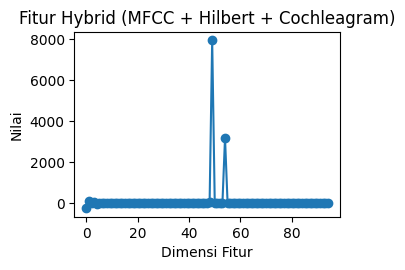

In [46]:
# Plot vektor hybrid
plt.subplot(2, 2, 4)
plt.plot(hybrid_vector, marker='o')
plt.title('Fitur Hybrid (MFCC + Hilbert + Cochleagram)')
plt.xlabel('Dimensi Fitur')
plt.ylabel('Nilai')

plt.tight_layout()
plt.show()

In [54]:
# Ambil 5 nilai pertama dari masing-masing fitur
df_fitur = pd.DataFrame({
    'MFCC': mfcc_feat[:5],
    'Hilbert': hilbert_feat[:5],
    'Cochleagram': cochlea_feat[:5]
})
print(df_fitur)

         MFCC   Hilbert  Cochleagram
0 -266.249878  0.144013     0.000441
1   77.101425  0.191938     0.000806
2  -19.249889  1.290790     0.002738
3   31.222151  0.000005     0.007247
4  -36.270615  0.070272     0.017915


In [48]:
print("MFCC  => Mean:", np.mean(mfcc_feat), "Std:", np.std(mfcc_feat))
print("Hilbert => Mean:", np.mean(hilbert_feat), "Std:", np.std(hilbert_feat))
print("Cochleagram => Mean:", np.mean(cochlea_feat), "Std:", np.std(cochlea_feat))

MFCC  => Mean: -9.635729 Std: 44.335773
Hilbert => Mean: 746.8318185948244 Std: 2077.2217445914375
Cochleagram => Mean: 0.010456831099750385 Std: 0.009853002450465291


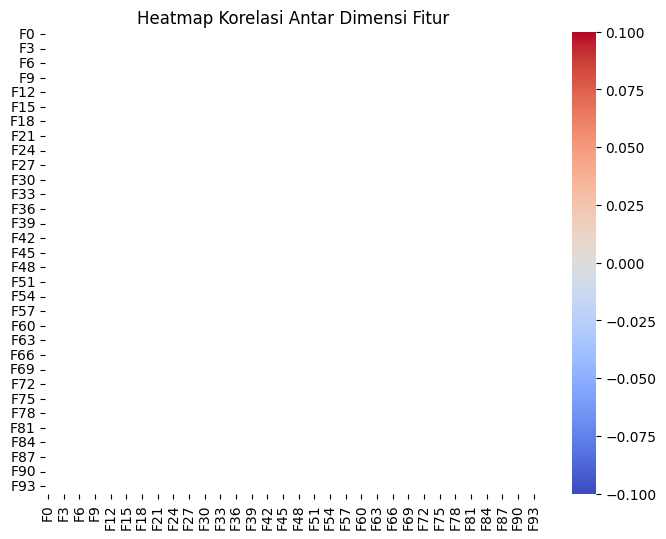

In [50]:
combined = np.concatenate([mfcc_feat, hilbert_feat, cochlea_feat])
df = pd.DataFrame(combined.reshape(1, -1), columns=[f'F{i}' for i in range(95)])
corr = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Heatmap Korelasi Antar Dimensi Fitur')
plt.show()

## Model CNN

In [27]:
input_shape = (hybrid_scaled.shape[1], 1)

model_cnn = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),                 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 256)           1536      
                                                                 
 batch_normalization (Batch  (None, 91, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 45, 256)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 45, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 128)           98432     
                                                                 
 batch_normalization_1 (Bat  (None, 43, 128)           5

In [28]:
# Training
history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=8)

Epoch 1/100
30/30 [==============================] - 11s 105ms/step - loss: 2.2867 - accuracy: 0.2708 - val_loss: 1.5893 - val_accuracy: 0.2667
Epoch 2/100
30/30 [==============================] - 4s 146ms/step - loss: 1.4231 - accuracy: 0.4250 - val_loss: 1.6269 - val_accuracy: 0.2333
Epoch 3/100
30/30 [==============================] - 3s 116ms/step - loss: 1.4985 - accuracy: 0.4625 - val_loss: 1.6893 - val_accuracy: 0.2167
Epoch 4/100
30/30 [==============================] - 5s 172ms/step - loss: 1.3443 - accuracy: 0.5333 - val_loss: 1.7971 - val_accuracy: 0.2167
Epoch 5/100
30/30 [==============================] - 4s 140ms/step - loss: 1.0952 - accuracy: 0.6125 - val_loss: 2.0571 - val_accuracy: 0.2000
Epoch 6/100
30/30 [==============================] - 4s 126ms/step - loss: 0.9624 - accuracy: 0.6250 - val_loss: 1.9855 - val_accuracy: 0.2000
Epoch 7/100
30/30 [==============================] - 4s 126ms/step - loss: 0.8904 - accuracy: 0.6792 - val_loss: 1.7085 - val_accuracy: 0.200

In [66]:
# Simpan model yang telah dilatih
model_cnn.save('dataset/model_cnn.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN

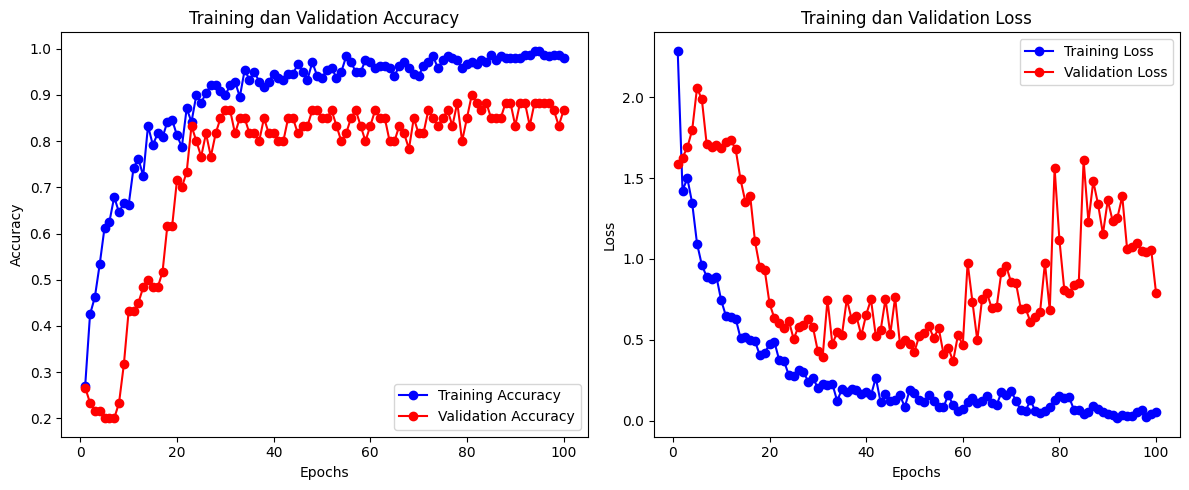

In [31]:
# Ambil nilai akurasi dan loss dari history
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history.get('val_accuracy')
loss = history_cnn.history['loss']
val_loss = history_cnn.history.get('val_loss')

# Hitung jumlah epoch
epochs = range(1, len(acc) + 1)

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
if val_acc is not None:
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training dan Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training dan Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluasi CNN

In [33]:
# Prediksi
y_pred_proba_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)
y_true_cnn = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 37ms/step


### Confusion Matrix CNN

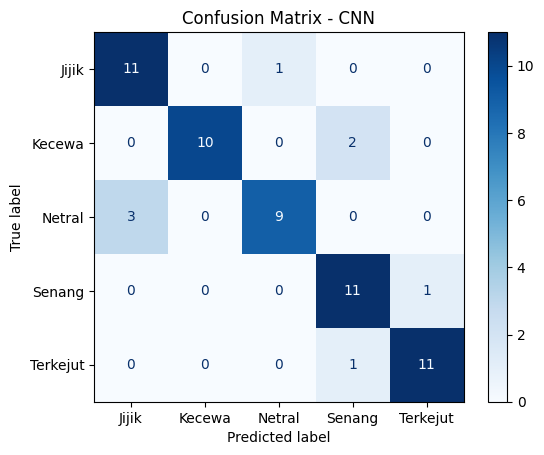

In [34]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics) CNN

In [35]:
print("Akurasi :", accuracy_score(y_true_cnn, y_pred_cnn))
print("Precision (macro):", precision_score(y_true_cnn, y_pred_cnn, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn, y_pred_cnn, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn, y_pred_cnn, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn, y_pred_cnn, target_names=labels))

Akurasi : 0.8666666666666667
Precision (macro): 0.8776190476190475
Recall (macro): 0.8666666666666666
F1-score (macro): 0.8672494172494172

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.79      0.92      0.85        12
      Kecewa       1.00      0.83      0.91        12
      Netral       0.90      0.75      0.82        12
      Senang       0.79      0.92      0.85        12
    Terkejut       0.92      0.92      0.92        12

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60



### AUC-ROC CNN

In [36]:
auc_roc_cnn = roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) :", auc_roc_cnn)

AUC-ROC (macro, ovr) : 0.9802083333333333


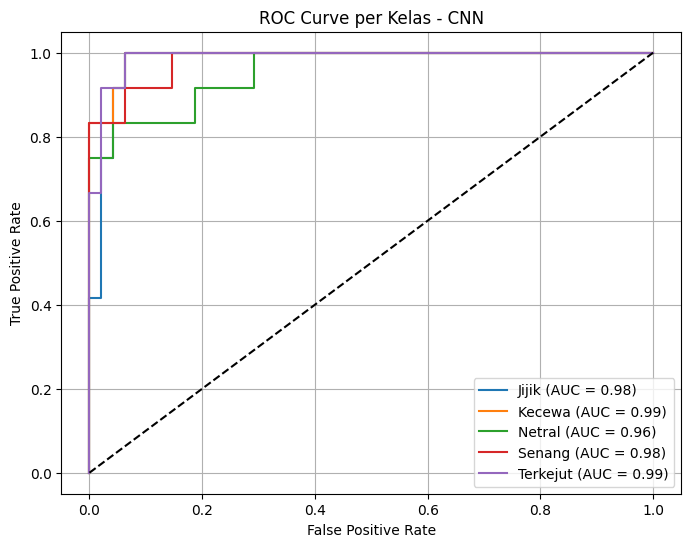

In [37]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_cnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN')
plt.legend()
plt.grid(True)
plt.show()

## Model LSTM

In [29]:
input_shape = (hybrid_scaled.shape[1], 1)

model_lstm = Sequential([
    LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(64, return_sequences=False, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 95, 128)           66560     
                                                                 
 batch_normalization_2 (Bat  (None, 95, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 95, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [30]:
# Training
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=8)

Epoch 1/150
30/30 [==============================] - 31s 409ms/step - loss: 2.1557 - accuracy: 0.2250 - val_loss: 1.5989 - val_accuracy: 0.2333
Epoch 2/150
30/30 [==============================] - 12s 390ms/step - loss: 2.0914 - accuracy: 0.1917 - val_loss: 1.5901 - val_accuracy: 0.2667
Epoch 3/150
30/30 [==============================] - 14s 446ms/step - loss: 1.9206 - accuracy: 0.2417 - val_loss: 1.6134 - val_accuracy: 0.2000
Epoch 4/150
30/30 [==============================] - 13s 426ms/step - loss: 1.8564 - accuracy: 0.2458 - val_loss: 1.6388 - val_accuracy: 0.2000
Epoch 5/150
30/30 [==============================] - 14s 448ms/step - loss: 1.9706 - accuracy: 0.2167 - val_loss: 1.8547 - val_accuracy: 0.2000
Epoch 6/150
30/30 [==============================] - 14s 453ms/step - loss: 1.9627 - accuracy: 0.2125 - val_loss: 1.7875 - val_accuracy: 0.2333
Epoch 7/150
30/30 [==============================] - 13s 449ms/step - loss: 1.9174 - accuracy: 0.2125 - val_loss: 1.7987 - val_accuracy:

In [84]:
# Simpan model yang telah dilatih
model_lstm.save('dataset/model_LSTM.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM

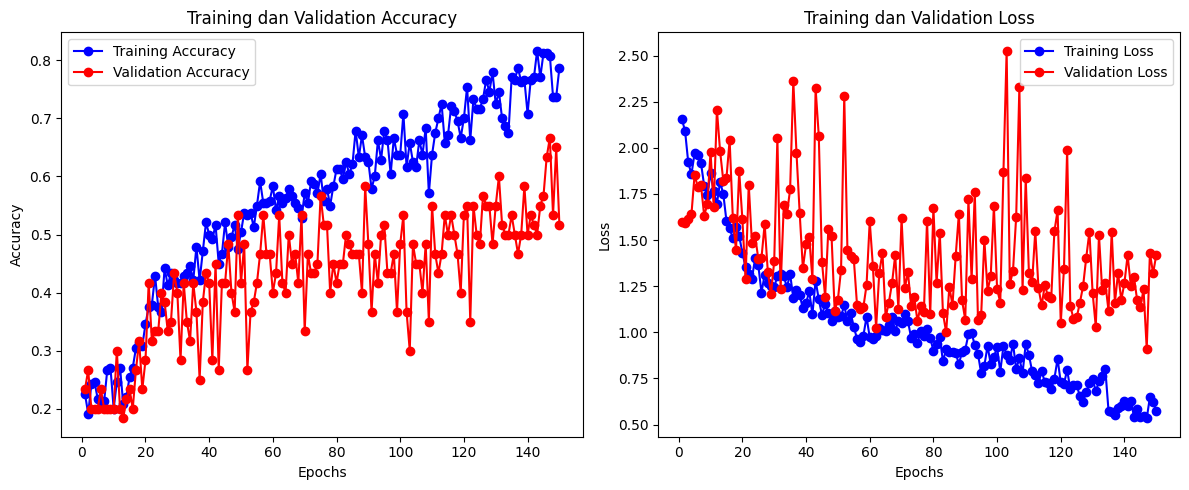

In [38]:
# Ambil nilai akurasi dan loss dari history
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history.get('val_accuracy')
loss = history_lstm.history['loss']
val_loss = history_lstm.history.get('val_loss')

# Hitung jumlah epoch
epochs = range(1, len(acc) + 1)

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
if val_acc is not None:
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training dan Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training dan Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluasi LSTM

In [39]:
# Prediksi
y_pred_proba_lstm = model_lstm.predict(X_test)
y_pred_lstm = np.argmax(y_pred_proba_lstm, axis=1)
y_true_lstm = np.argmax(y_test, axis=1)

2/2 [==============================] - 6s 198ms/step


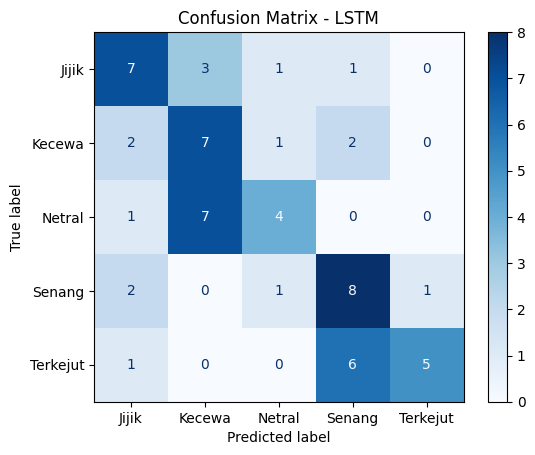

In [40]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_lstm, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics) LSTM

In [81]:
print("Akurasi :", accuracy_score(y_true_lstm, y_pred_lstm))
print("Precision (macro):", precision_score(y_true_lstm, y_pred_lstm, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm, y_pred_lstm, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm, y_pred_lstm, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm, y_pred_lstm, target_names=labels))

Akurasi : 0.8
Precision (macro): 0.8085214785214785
Recall (macro): 0.8
F1-score (macro): 0.8013955609607784

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.90      0.75      0.82        12
      Kecewa       0.77      0.83      0.80        12
      Netral       0.91      0.83      0.87        12
      Senang       0.75      0.75      0.75        12
    Terkejut       0.71      0.83      0.77        12

    accuracy                           0.80        60
   macro avg       0.81      0.80      0.80        60
weighted avg       0.81      0.80      0.80        60



### AUC-ROC LSTM

In [82]:
auc_roc_lstm = roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) LSTM:", auc_roc_lstm)

AUC-ROC (macro, ovr) LSTM: 0.9552083333333334


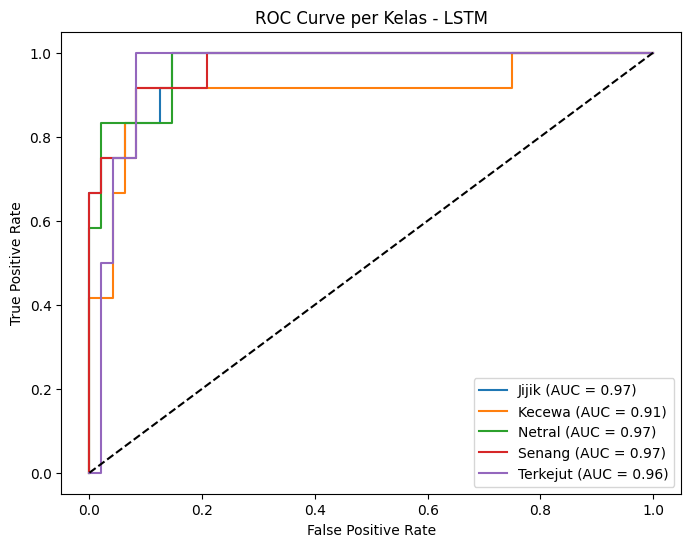

In [83]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_lstm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM')
plt.legend()
plt.show()

## Model CNN + LSTM

In [95]:
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy

input_shape = (hybrid_scaled.shape[1], 1)

modelEXP = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', padding='same',
           kernel_initializer='he_normal', kernel_regularizer=l2(0.0001), input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = Adam(learning_rate=0.0005)

modelEXP.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])


In [292]:
modelEXP.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 95, 256)           1536      
                                                                 
 batch_normalization_81 (Ba  (None, 95, 256)           1024      
 tchNormalization)                                               
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 47, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_109 (Dropout)       (None, 47, 256)           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 45, 128)           98432     
                                                                 
 batch_normalization_82 (Ba  (None, 45, 128)         

In [96]:
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy

input_shape = (hybrid_scaled.shape[1], 1)

model_hybridEXP = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', padding='same',
           kernel_initializer='he_normal', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),

    LSTM(64, return_sequences=False, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = Adam(learning_rate=0.0005)

model_hybridEXP.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

model_hybridEXP.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 95, 256)           1536      
                                                                 
 batch_normalization_28 (Ba  (None, 95, 256)           1024      
 tchNormalization)                                               
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 47, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_38 (Dropout)        (None, 47, 256)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 45, 128)           98432     
                                                                 
 batch_normalization_29 (Ba  (None, 45, 128)          

In [97]:
historyEXP = modelEXP.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32)

Epoch 1/150
8/8 [==============================] - 28s 843ms/step - loss: 2.1708 - accuracy: 0.2333 - val_loss: 1.7416 - val_accuracy: 0.2000
Epoch 2/150
8/8 [==============================] - 3s 317ms/step - loss: 2.1753 - accuracy: 0.2083 - val_loss: 1.7439 - val_accuracy: 0.2000
Epoch 3/150
8/8 [==============================] - 3s 329ms/step - loss: 2.0858 - accuracy: 0.2167 - val_loss: 1.7434 - val_accuracy: 0.2000
Epoch 4/150
8/8 [==============================] - 4s 522ms/step - loss: 1.8841 - accuracy: 0.2750 - val_loss: 1.7473 - val_accuracy: 0.2000
Epoch 5/150
8/8 [==============================] - 4s 511ms/step - loss: 1.8895 - accuracy: 0.2750 - val_loss: 1.7479 - val_accuracy: 0.2333
Epoch 6/150
8/8 [==============================] - 4s 538ms/step - loss: 1.8500 - accuracy: 0.3333 - val_loss: 1.7589 - val_accuracy: 0.2500
Epoch 7/150
8/8 [==============================] - 4s 510ms/step - loss: 1.8564 - accuracy: 0.2875 - val_loss: 1.7655 - val_accuracy: 0.2000
Epoch 8/150


In [99]:
history_hybridEXP = model_hybridEXP.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32)

Epoch 1/150
8/8 [==============================] - 29s 836ms/step - loss: 2.3773 - accuracy: 0.1667 - val_loss: 1.6078 - val_accuracy: 0.2333
Epoch 2/150
8/8 [==============================] - 2s 310ms/step - loss: 2.0576 - accuracy: 0.2833 - val_loss: 1.6063 - val_accuracy: 0.2000
Epoch 3/150
8/8 [==============================] - 3s 320ms/step - loss: 1.9262 - accuracy: 0.2750 - val_loss: 1.6088 - val_accuracy: 0.2000
Epoch 4/150
8/8 [==============================] - 4s 524ms/step - loss: 1.8855 - accuracy: 0.2417 - val_loss: 1.6106 - val_accuracy: 0.2000
Epoch 5/150
8/8 [==============================] - 4s 521ms/step - loss: 1.8623 - accuracy: 0.2542 - val_loss: 1.6147 - val_accuracy: 0.2000
Epoch 6/150
8/8 [==============================] - 4s 528ms/step - loss: 1.7823 - accuracy: 0.2792 - val_loss: 1.6216 - val_accuracy: 0.2000
Epoch 7/150
8/8 [==============================] - 4s 518ms/step - loss: 1.7040 - accuracy: 0.2833 - val_loss: 1.6259 - val_accuracy: 0.2000
Epoch 8/150


In [100]:
# Simpan model yang telah dilatih
model_hybridEXP.save('dataset/model_hybridEXP.h5')
modelEXP.save('dataset/model_hybrid.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi Hybrid

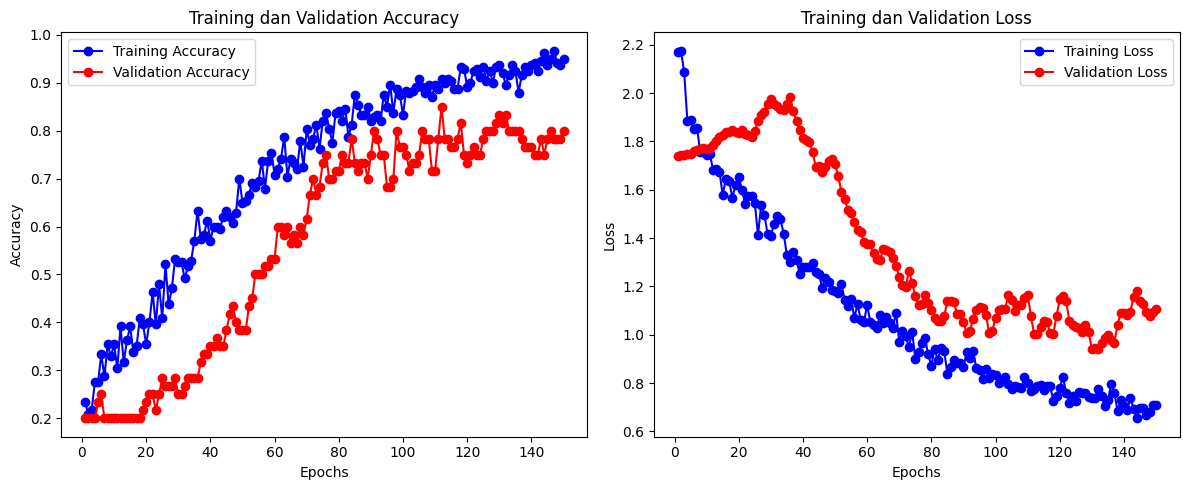

In [98]:
# Ambil nilai akurasi dan loss dari history
acc = historyEXP.history['accuracy']
val_acc = historyEXP.history.get('val_accuracy')
loss = historyEXP.history['loss']
val_loss = historyEXP.history.get('val_loss')

# Hitung jumlah epoch
epochs = range(1, len(acc) + 1)

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
if val_acc is not None:
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training dan Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training dan Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

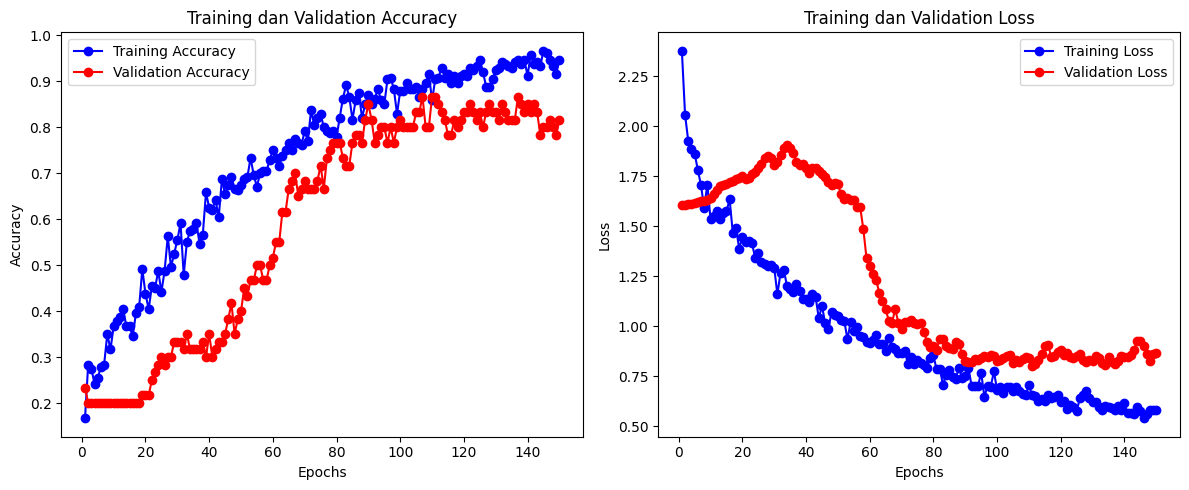

In [101]:
# Ambil nilai akurasi dan loss dari history
acc = history_hybridEXP.history['accuracy']
val_acc = history_hybridEXP.history.get('val_accuracy')
loss = history_hybridEXP.history['loss']
val_loss = history_hybridEXP.history.get('val_loss')

# Hitung jumlah epoch
epochs = range(1, len(acc) + 1)

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
if val_acc is not None:
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training dan Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training dan Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluasi Hybrid

In [102]:
# Prediksi
y_pred_proba_hybrid = modelEXP.predict(X_test)
y_pred_hybrid = np.argmax(y_pred_proba_hybrid, axis=1)
y_true_hybrid = np.argmax(y_test, axis=1)

2/2 [==============================] - 3s 86ms/step


In [103]:
# Prediksi
y_pred_proba_hybridEXP = model_hybridEXP.predict(X_test)
y_pred_hybridEXP = np.argmax(y_pred_proba_hybridEXP, axis=1)
y_true_hybridEXP = np.argmax(y_test, axis=1)

2/2 [==============================] - 4s 88ms/step


### Confusion Matrix Hybrid

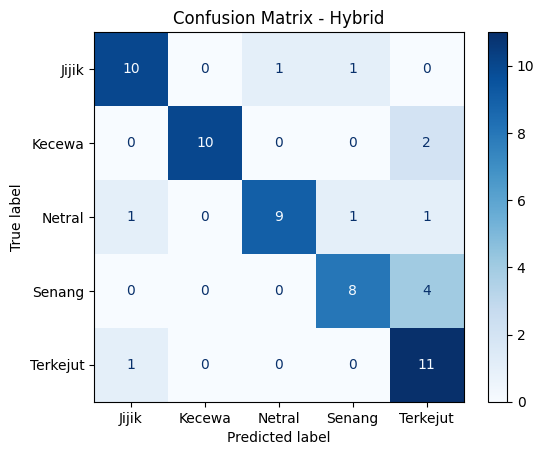

In [104]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_hybrid, y_pred_hybrid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Hybrid')
plt.show()

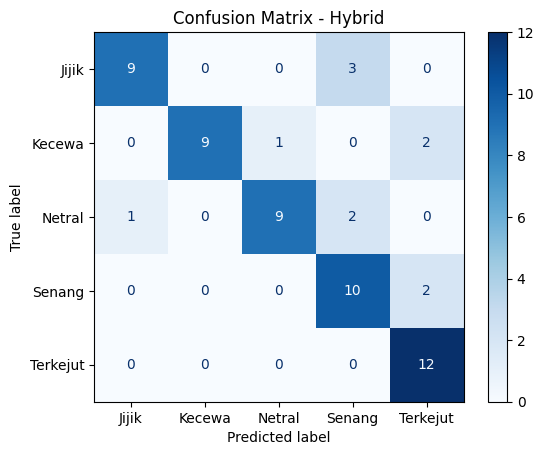

In [105]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_hybridEXP, y_pred_hybridEXP)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Hybrid')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics) Hybrid

In [106]:
print("Akurasi Hybrid:", accuracy_score(y_true_hybrid, y_pred_hybrid))
print("Precision (macro):", precision_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("Recall (macro):", recall_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("F1-score (macro):", f1_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_hybrid, y_pred_hybrid, target_names=labels))

Akurasi Hybrid: 0.8
Precision (macro): 0.8288888888888888
Recall (macro): 0.8
F1-score (macro): 0.8042424242424243

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.83      0.83      0.83        12
      Kecewa       1.00      0.83      0.91        12
      Netral       0.90      0.75      0.82        12
      Senang       0.80      0.67      0.73        12
    Terkejut       0.61      0.92      0.73        12

    accuracy                           0.80        60
   macro avg       0.83      0.80      0.80        60
weighted avg       0.83      0.80      0.80        60



In [107]:
print("Akurasi Hybrid:", accuracy_score(y_true_hybridEXP, y_pred_hybridEXP))
print("Precision (macro):", precision_score(y_true_hybridEXP, y_pred_hybridEXP, average='macro'))
print("Recall (macro):", recall_score(y_true_hybridEXP, y_pred_hybridEXP, average='macro'))
print("F1-score (macro):", f1_score(y_true_hybridEXP, y_pred_hybridEXP, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_hybridEXP, y_pred_hybridEXP, target_names=labels))

Akurasi Hybrid: 0.8166666666666667
Precision (macro): 0.8433333333333334
Recall (macro): 0.8166666666666668
F1-score (macro): 0.8182780182780183

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.90      0.75      0.82        12
      Kecewa       1.00      0.75      0.86        12
      Netral       0.90      0.75      0.82        12
      Senang       0.67      0.83      0.74        12
    Terkejut       0.75      1.00      0.86        12

    accuracy                           0.82        60
   macro avg       0.84      0.82      0.82        60
weighted avg       0.84      0.82      0.82        60



### AUC-ROC Hybrid CNN + LSTM 

In [108]:
auc_roc_hybrid = roc_auc_score(y_test, y_pred_proba_hybrid, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) Hybrid:", auc_roc_hybrid)

AUC-ROC (macro, ovr) Hybrid: 0.9402777777777779


In [109]:
auc_roc_hybridEXP = roc_auc_score(y_test, y_pred_proba_hybridEXP, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) Hybrid:", auc_roc_hybridEXP)

AUC-ROC (macro, ovr) Hybrid: 0.9638888888888889


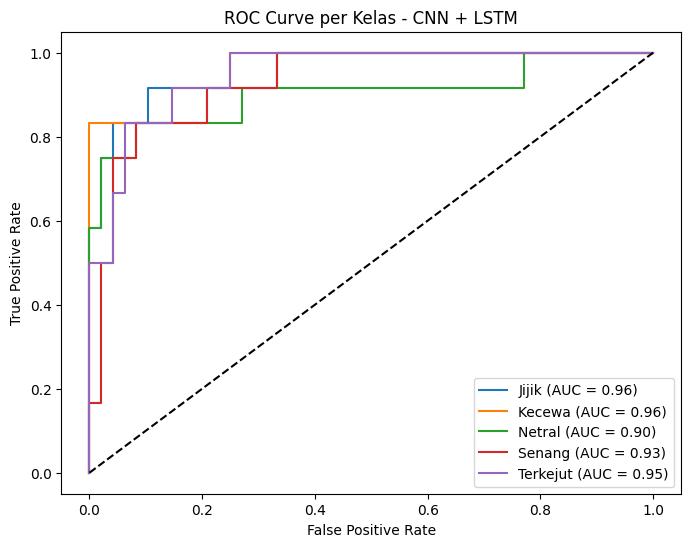

In [110]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN + LSTM')
plt.legend()
plt.show()

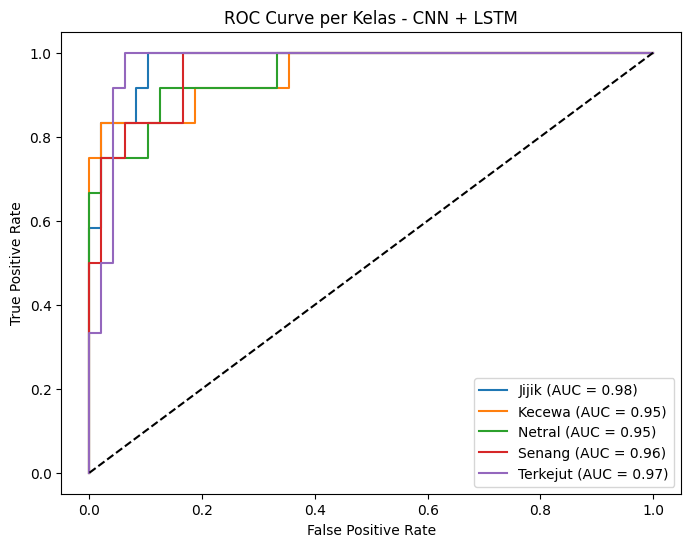

In [111]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_hybridEXP[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN + LSTM')
plt.legend()
plt.show()

# Perbandingan Kinerja antar Model

In [114]:
# Kumpulkan semua metrik ke dalam dictionary
metrics_data = {
    'Model': ['CNN', 'LSTM', 'Hybrid (CNN+LSTM)'],
    'Akurasi': [
        accuracy_score(y_true_cnn, y_pred_cnn),
        accuracy_score(y_true_lstm, y_pred_lstm),
        accuracy_score(y_true_hybridEXP, y_pred_hybridEXP),
    ],
    'Precision (macro)': [
        precision_score(y_true_cnn, y_pred_cnn, average='macro'),
        precision_score(y_true_lstm, y_pred_lstm, average='macro'),
        precision_score(y_true_hybridEXP, y_pred_hybridEXP, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_true_cnn, y_pred_cnn, average='macro'),
        recall_score(y_true_lstm, y_pred_lstm, average='macro'),
        recall_score(y_true_hybridEXP, y_pred_hybridEXP, average='macro')
    ],
    'F1-score (macro)': [
        f1_score(y_true_cnn, y_pred_cnn, average='macro'),
        f1_score(y_true_lstm, y_pred_lstm, average='macro'),
        f1_score(y_true_hybridEXP, y_pred_hybridEXP, average='macro')
    ],
    'AUC-ROC (macro)': [
        roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_hybridEXP, average='macro', multi_class='ovr')
    ]
}

# Buat DataFrame
comparison_df = pd.DataFrame(metrics_data)
print("Tabel Perbandingan Kinerja Model:")
print(comparison_df.to_string())

Tabel Perbandingan Kinerja Model:
               Model   Akurasi  Precision (macro)  Recall (macro)  F1-score (macro)  AUC-ROC (macro)
0                CNN  0.883333           0.892564        0.883333          0.882566         0.990278
1               LSTM  0.800000           0.808521        0.800000          0.801396         0.955208
2  Hybrid (CNN+LSTM)  0.816667           0.843333        0.816667          0.818278         0.963889


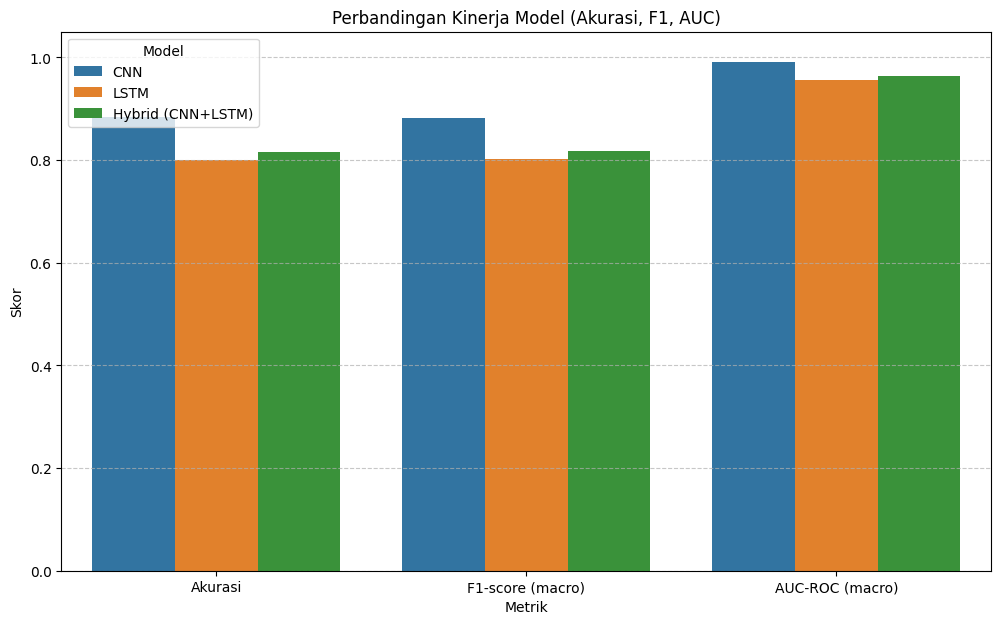

In [115]:
# Siapkan data untuk plot
plot_df = comparison_df.melt(id_vars='Model', value_vars=['Akurasi', 'F1-score (macro)', 'AUC-ROC (macro)'],
                             var_name='Metrik', value_name='Skor')

# Buat bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df, x='Metrik', y='Skor', hue='Model')
plt.title('Perbandingan Kinerja Model (Akurasi, F1, AUC)')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [116]:
# Siapkan probabilitas dari setiap model
models_proba = {
    'CNN': y_pred_proba_cnn,
    'LSTM': y_pred_proba_lstm,
    'Hybrid (CNN+LSTM)': y_pred_proba_hybridEXP
}

plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

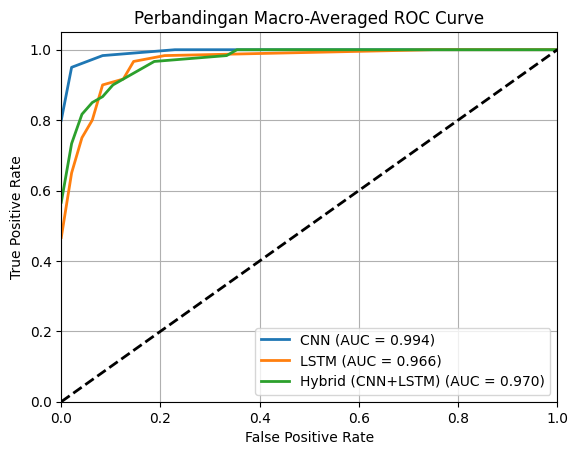

In [117]:
# Loop untuk setiap model
for model_name, y_pred_proba in models_proba.items():
    # Hitung macro-average ROC
    n_classes = y_test.shape[1]
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'{model_name} (AUC = {macro_auc:.3f})',
             linewidth=2)

# Plot garis referensi
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan Macro-Averaged ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()